In [1]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [3]:
test_data_path = '/content/drive/MyDrive/final_project/final_project_step1_radiomic_features.csv'
test_data = pd.read_csv(test_data_path)

In [4]:
clinical_data = pd.read_excel ("/content/drive/My Drive/final_project/TCGA_GBM_LGG_clinical_data_for_task2_updated.xlsx")
pyradiomics_data = pd.read_csv("/content/drive/My Drive/final_project/TCGA_pyradiomics_t1.csv")



In [5]:
# Merge both the data
merged_df = pd.merge(pyradiomics_data, clinical_data, left_on="ID", right_on="Row.names")

In [6]:
X = merged_df.drop(columns=["Disease_Type"])
y = merged_df["Disease_Type"]

In [7]:
import numpy as np
# replace non-numeric data with NaN
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = np.nan

# drop columns with any NaN values
X.dropna(axis=1, inplace=True)

In [8]:
# keep only the columns with numeric data types
X_numeric = X.select_dtypes(include=[np.number])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

In [10]:
# filter out 'Oligoastrocytoma' samples from X_numeric and y
X_numeric_filtered = X_numeric[~(y == 'Oligoastrocytoma')]
y_filtered = y[~(y == 'Oligoastrocytoma')]

In [11]:
# Splitting the filtered data into training and testing sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_numeric_filtered, y_filtered, test_size=0.2, random_state=42)

In [12]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the filtered training data
rf_classifier.fit(X_train_filtered, y_train_filtered)

RandomForestClassifier(random_state=42)

In [13]:
# Predict on the filtered test data
from sklearn.metrics import classification_report

y_pred_rf = rf_classifier.predict(X_test_filtered)

print("Random Forest Classification Report:")
print(classification_report(y_test_filtered, y_pred_rf))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.82      0.90      0.86        20
Oligodendroglioma       0.50      0.43      0.46         7

         accuracy                           0.70        30
        macro avg       0.44      0.44      0.44        30
     weighted avg       0.66      0.70      0.68        30



In [14]:
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

# Assuming you've already defined and trained rf_classifier
y_pred_rf = rf_classifier.predict(X_test_filtered)

print("Random Forest Classification Report:")
print(classification_report(y_test_filtered, y_pred_rf))

# Now, let's do Gradient Boosting
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_filtered, y_train_filtered)

# Predict using Gradient Boosting
y_pred_gb = gb_classifier.predict(X_test_filtered)

# Print classification report for Gradient Boosting
print("Gradient Boosting Classification Report:")
print(classification_report(y_test_filtered, y_pred_gb))


Random Forest Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.82      0.90      0.86        20
Oligodendroglioma       0.50      0.43      0.46         7

         accuracy                           0.70        30
        macro avg       0.44      0.44      0.44        30
     weighted avg       0.66      0.70      0.68        30

Gradient Boosting Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.84      0.80      0.82        20
Oligodendroglioma       0.50      0.43      0.46         7

         accuracy                           0.63        30
        macro avg       0.45      0.41      0.43        30
     weighted avg       0.68      0.63      0.65        30



In [15]:
rembrandt_features = test_data[X_train_filtered.columns]

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Initialize the scaler
scaler = StandardScaler()

scaler.fit(X_train_filtered)
X_train_scaled = scaler.transform(X_train_filtered)

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier on the scaled training data
svm_classifier.fit(X_train_scaled, y_train_filtered)

SVC(kernel='linear', random_state=42)

In [17]:
# Apply the scaler that was fit on the training data
rembrandt_features_scaled = scaler.transform(rembrandt_features)

In [18]:
rembrandt_predictions = svm_classifier.predict(rembrandt_features_scaled)

# Create a DataFrame with predictions and patient IDs
results_df = pd.DataFrame({
    'Patient_ID': test_data['Folder_ID'],
    'Predicted_Cancer_Type': rembrandt_predictions
})
print("Predictions with Patient IDs:")
print(results_df.head())

Predictions with Patient IDs:
          Patient_ID Predicted_Cancer_Type
0  HF1409_1994.09.23                   GBM
1  HF1458_1994.12.28                   GBM
2  HF1381_1994.08.12     Oligodendroglioma
3  HF1433_1994.11.11                   GBM
4  HF1318_1994.04.23                   GBM


In [19]:
# Create a common index for both datasets
clinical_data['index'] = range(len(clinical_data))
test_data['index'] = range(len(test_data))

In [20]:
# Merge the two datasets on the common index
merged_data = pd.merge(clinical_data, test_data, on='index', how='inner')

# Drop the common index column
merged_data.drop('index', axis=1, inplace=True)

In [21]:
from sklearn.metrics import classification_report

# Load the actual labels of the merged dataset
actual_labels = merged_data['Disease_Type']

# Generate classification report
classification_rep = classification_report(actual_labels, rembrandt_predictions)

# Display the classification report
print("Classification Report from SVM Model:\n", classification_rep)

Classification Report from SVM Model:
                    precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         0
              GBM       1.00      0.66      0.79        64
Oligodendroglioma       0.00      0.00      0.00         0

         accuracy                           0.66        64
        macro avg       0.33      0.22      0.26        64
     weighted avg       1.00      0.66      0.79        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.metrics import classification_report

# Generate classification report for Random Forest
classification_rep_rf = classification_report(actual_labels, rembrandt_predictions)

# Display the classification report for Random Forest
print("Classification Report from Random Forest Model:\n", classification_rep_rf)


Classification Report from Random Forest Model:
                    precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         0
              GBM       1.00      0.66      0.79        64
Oligodendroglioma       0.00      0.00      0.00         0

         accuracy                           0.66        64
        macro avg       0.33      0.22      0.26        64
     weighted avg       1.00      0.66      0.79        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Initialize and train KNN
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)

# Generate classification report for KNN
knn_classification_rep = classification_report(actual_labels, rembrandt_predictions)

# Display the classification report for KNN
print("Classification Report from KNN Model:\n", knn_classification_rep)

# Initialize and train SVM
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# Generate classification report for SVM
svm_classification_rep = classification_report(actual_labels, rembrandt_predictions)

# Display the classification report for SVM
print("Classification Report from SVM Model:\n", svm_classification_rep)


Classification Report from KNN Model:
                    precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         0
              GBM       1.00      0.66      0.79        64
Oligodendroglioma       0.00      0.00      0.00         0

         accuracy                           0.66        64
        macro avg       0.33      0.22      0.26        64
     weighted avg       1.00      0.66      0.79        64

Classification Report from SVM Model:
                    precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         0
              GBM       1.00      0.66      0.79        64
Oligodendroglioma       0.00      0.00      0.00         0

         accuracy                           0.66        64
        macro avg       0.33      0.22      0.26        64
     weighted avg       1.00      0.66      0.79        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

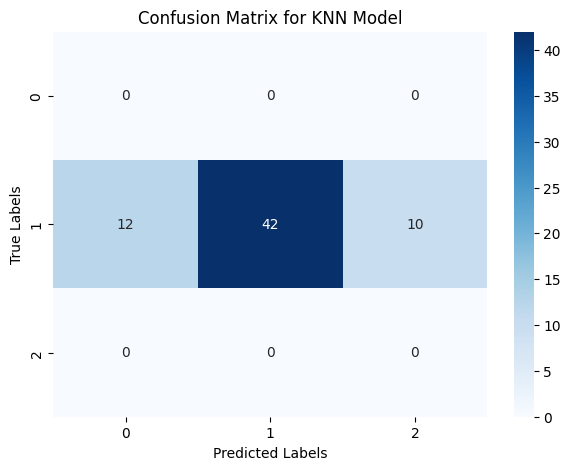

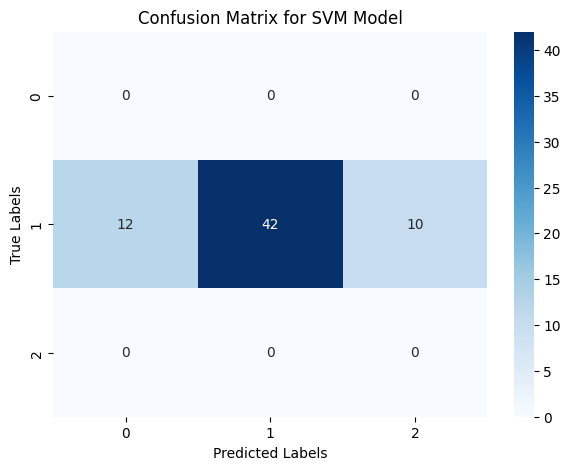

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix for KNN
conf_matrix_knn = confusion_matrix(actual_labels, rembrandt_predictions)

# Plotting the confusion matrix for KNN
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN Model')
plt.show()

# Calculate the confusion matrix for SVM
conf_matrix_svm = confusion_matrix(actual_labels, rembrandt_predictions)

# Plotting the confusion matrix for SVM
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()


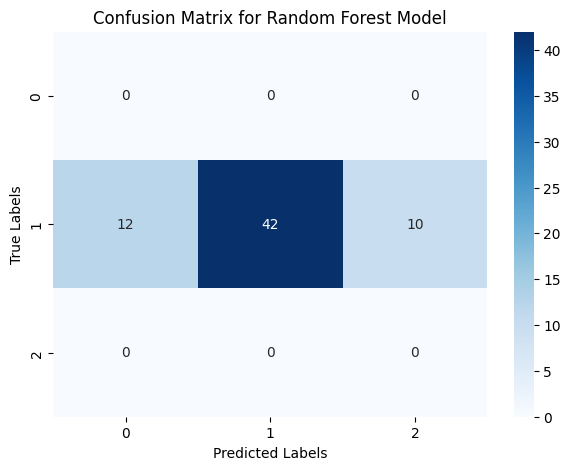

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(actual_labels, rembrandt_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


STEP 4

In [25]:
ground_truth_path = '/content/drive/MyDrive/final_project/Rembrandt_Clinical_ground_truth_64set.txt'

ground_truth_data = pd.read_csv(ground_truth_path, sep= '\t')

print(ground_truth_data.head())

  64.patient.set AGE_RANGE GENDER DISEASE_TYPE
0    900_00_5299       NaN    NaN          NaN
1    900_00_5303       NaN    NaN          NaN
2    900_00_5308       NaN         ASTROCYTOMA
3    900_00_5316       NaN                 GBM
4    900_00_5317       NaN                 GBM


In [26]:
print(results_df)

                Patient_ID Predicted_Cancer_Type
0        HF1409_1994.09.23                   GBM
1        HF1458_1994.12.28                   GBM
2        HF1381_1994.08.12     Oligodendroglioma
3        HF1433_1994.11.11                   GBM
4        HF1318_1994.04.23                   GBM
..                     ...                   ...
59  900-00-5385_2005.08.07           Astrocytoma
60  900-00-5476_2005.12.04           Astrocytoma
61  900-00-5404_2005.09.03                   GBM
62  900-00-5459_2005.11.21     Oligodendroglioma
63  900-00-5396_2005.08.13                   GBM

[64 rows x 2 columns]


In [27]:
print("Number of rows in ground_truth_data:", ground_truth_data.shape[0])
print("Number of rows in results_df:", results_df.shape[0])

Number of rows in ground_truth_data: 64
Number of rows in results_df: 64


In [28]:
print(ground_truth_data[['64.patient.set']].head())
print(results_df[['Patient_ID']].head())

  64.patient.set
0    900_00_5299
1    900_00_5303
2    900_00_5308
3    900_00_5316
4    900_00_5317
          Patient_ID
0  HF1409_1994.09.23
1  HF1458_1994.12.28
2  HF1381_1994.08.12
3  HF1433_1994.11.11
4  HF1318_1994.04.23


In [29]:
# Sort by an identifier
ground_truth_data.sort_values(by='64.patient.set', inplace=True)
results_df.sort_values(by= 'Patient_ID', inplace=True)

In [30]:
ground_truth_data.reset_index(drop=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)

In [31]:
# Concatenate the DataFrames
merged_data = pd.concat([results_df, ground_truth_data], axis=1)
print(merged_data.head())

               Patient_ID Predicted_Cancer_Type 64.patient.set AGE_RANGE  \
0  900-00-5299_2005.03.22                   GBM    900_00_5299       NaN   
1  900-00-5303_2005.03.24                   GBM    900_00_5303       NaN   
2  900-00-5308_2005.04.24                   GBM    900_00_5308       NaN   
3  900-00-5316_2005.04.24                   GBM    900_00_5316       NaN   
4  900-00-5317_2005.04.24                   GBM    900_00_5317       NaN   

  GENDER DISEASE_TYPE  
0    NaN          NaN  
1    NaN          NaN  
2         ASTROCYTOMA  
3                 GBM  
4                 GBM  


In [32]:
# NaN values in columns
print(merged_data.isnull().sum())

print(merged_data.head())

Patient_ID                0
Predicted_Cancer_Type     0
64.patient.set            0
AGE_RANGE                24
GENDER                    6
DISEASE_TYPE              6
dtype: int64
               Patient_ID Predicted_Cancer_Type 64.patient.set AGE_RANGE  \
0  900-00-5299_2005.03.22                   GBM    900_00_5299       NaN   
1  900-00-5303_2005.03.24                   GBM    900_00_5303       NaN   
2  900-00-5308_2005.04.24                   GBM    900_00_5308       NaN   
3  900-00-5316_2005.04.24                   GBM    900_00_5316       NaN   
4  900-00-5317_2005.04.24                   GBM    900_00_5317       NaN   

  GENDER DISEASE_TYPE  
0    NaN          NaN  
1    NaN          NaN  
2         ASTROCYTOMA  
3                 GBM  
4                 GBM  


In [33]:
merged_data = merged_data[merged_data['DISEASE_TYPE'].notna() & merged_data['DISEASE_TYPE'].str.strip().ne('')]
print("Number of remaining entries:", merged_data.shape[0])

Number of remaining entries: 58


In [34]:
# Convert 'DISEASE_TYPE' and 'Predicted_Cancer_Type' to the same case format
merged_data['DISEASE_TYPE'] = merged_data['DISEASE_TYPE'].str.upper()
merged_data['Predicted_Cancer_Type'] = merged_data['Predicted_Cancer_Type'].str.upper()

print("Unique Disease Types:", merged_data['DISEASE_TYPE'].unique())

Unique Disease Types: ['ASTROCYTOMA' 'GBM' 'OLIGODENDROGLIOMA']


In [35]:
y_true = merged_data['DISEASE_TYPE']
y_pred = merged_data['Predicted_Cancer_Type']

In [36]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print("Classification Report of SVM model:")
print(report)

Classification Report of SVM model:
                   precision    recall  f1-score   support

      ASTROCYTOMA       0.64      0.25      0.36        28
              GBM       0.47      1.00      0.64        18
OLIGODENDROGLIOMA       0.11      0.08      0.10        12

         accuracy                           0.45        58
        macro avg       0.41      0.44      0.37        58
     weighted avg       0.48      0.45      0.39        58



Confusion Matrix:
[[ 7 13  8]
 [ 0 18  0]
 [ 4  7  1]]


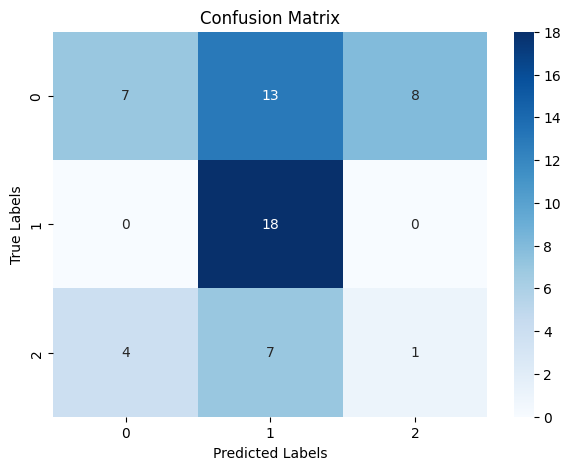

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report for Random Forest
report_rf = classification_report(y_true, y_pred)
print("Classification Report of Random Forest model:")
print(report_rf)

# Generate confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix for Random Forest:")
print(conf_matrix_rf)


Classification Report of Random Forest model:
                   precision    recall  f1-score   support

      ASTROCYTOMA       0.64      0.25      0.36        28
              GBM       0.47      1.00      0.64        18
OLIGODENDROGLIOMA       0.11      0.08      0.10        12

         accuracy                           0.45        58
        macro avg       0.41      0.44      0.37        58
     weighted avg       0.48      0.45      0.39        58


Confusion Matrix for Random Forest:
[[ 7 13  8]
 [ 0 18  0]
 [ 4  7  1]]


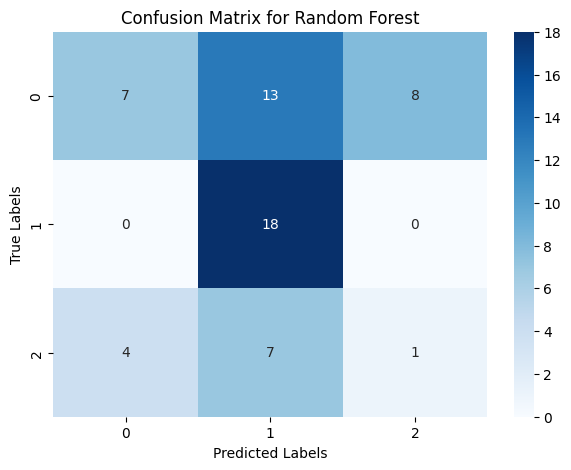

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix for Random Forest
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report for KNN
report_knn = classification_report(y_true, y_pred)
print("Classification Report of KNN model:")
print(report_knn)

# Generate confusion matrix for KNN
conf_matrix_knn = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix for KNN:")
print(conf_matrix_knn)


Classification Report of KNN model:
                   precision    recall  f1-score   support

      ASTROCYTOMA       0.64      0.25      0.36        28
              GBM       0.47      1.00      0.64        18
OLIGODENDROGLIOMA       0.11      0.08      0.10        12

         accuracy                           0.45        58
        macro avg       0.41      0.44      0.37        58
     weighted avg       0.48      0.45      0.39        58


Confusion Matrix for KNN:
[[ 7 13  8]
 [ 0 18  0]
 [ 4  7  1]]


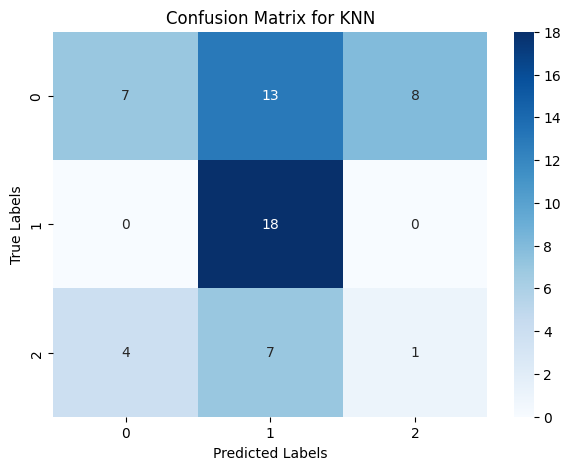

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix for KNN
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN')
plt.show()
